In [76]:
import pandas as pd
import numpy as np
import cvxpy as cp
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [77]:
# Define the file path
file_path = r"C:\Users\skosloff\Documents\Mean-Variance Analysis\BR MV Data 2.xlsx"

# Load the Excel file
# If the file has multiple sheets, specify the sheet name or index
retvol = pd.read_excel(file_path, sheet_name='RetVol')  
corr = pd.read_excel(file_path, sheet_name='Corr')  


# Drop columns
retvol.drop(retvol.columns[[0, 1, 3]], axis=1, inplace=True)

# Set the second row as the column headers
retvol.columns = retvol.iloc[1]
retvol = retvol[2:]  

# Drop columns
corr.drop(corr.columns[[0,1]], axis=1, inplace=True)

# Set the second row as the column headers
corr.columns = corr.iloc[1]
corr = corr[2:]  

# Set index of corr
corr.set_index('Asset', inplace=True)

C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\skosloff\AppData\Local\anaconda3\envs\PortOpt\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [78]:
corr

1,U.S. large cap equities,U.S. small cap equities,U.S. credit (all maturities),U.S. government bonds (all maturities),U.S. cash,U.S. private equity (buyout),Real estate mezzanine debt,Hedge funds (global),U.S. core real estate,Global infrastructure equity
Asset,,,,,,,,,,
U.S. large cap equities,1,0.92901,0.28187,-0.19369,0,0.80449,0.72371,0.42898,0.68739,0.7494
U.S. small cap equities,0.92901,1,0.30407,-0.22887,0,0.86445,0.78392,0.4501,0.70685,0.75408
U.S. credit (all maturities),0.28187,0.30407,1,0.70904,0,0.27018,0.58599,0.14768,0.45834,0.29228
U.S. government bonds (all maturities),-0.19369,-0.22887,0.70904,1,0,-0.19047,0.06488,-0.1082,0.06264,-0.13539
U.S. cash,0,0,0,0,1,0,0,0,0,0
U.S. private equity (buyout),0.80449,0.86445,0.27018,-0.19047,0,1,0.6864,0.39052,0.62454,0.65175
Real estate mezzanine debt,0.72371,0.78392,0.58599,0.06488,0,0.6864,1,0.37128,0.85174,0.70039
Hedge funds (global),0.42898,0.4501,0.14768,-0.1082,0,0.39052,0.37128,1,0.32149,0.36403
U.S. core real estate,0.68739,0.70685,0.45834,0.06264,0,0.62454,0.85174,0.32149,1,0.56668


In [79]:
# Reorder correlation matrix to match retvol
new_order = [
    'U.S. cash', 
    'U.S. government bonds (all maturities)', 
    'U.S. large cap equities', 
    'Hedge funds (global)', 
    'U.S. credit (all maturities)', 
    'U.S. private equity (buyout)', 
    'U.S. small cap equities', 
    'Global infrastructure equity', 
    'Real estate mezzanine debt', 
    'U.S. core real estate'
]

# Reindex the correlation matrix
corr = corr.reindex(index=new_order, columns=new_order)

In [80]:
# Define expected returns, correlation matrix, and variances for 10 assets
expected_returns = retvol['Expected Return (10yr)'].values
correlations = corr.values
variances = retvol['Volatility'].values


# Convert to float
expected_returns = np.array(expected_returns, dtype=float)
variances = np.array(variances, dtype=float)
correlations = np.array(correlations, dtype=float)

# Convert variances to standard deviations
std_devs = np.sqrt(variances)

# Calculate covariance matrix from correlation matrix and variances
cov_matrix = np.diag(std_devs) @ corr @ np.diag(std_devs)

# Define the number of assets
n_assets = len(expected_returns)

# Define the optimization variable for portfolio weights
weights = cp.Variable(n_assets)

# Define the expected return and risk (volatility) constraints
portfolio_return = expected_returns @ weights
portfolio_risk = cp.quad_form(weights, cov_matrix)

In [81]:
# Define constraints
constraints = [
    cp.sum(weights) == 1,  # Weights must sum to 1
    weights >= 0.01,          # No short selling and keep positions above 1%
    portfolio_risk <= 0.01  # Keep portfolio volatility under 10%
]

In [84]:
# Define the objective function to maximize expected return
objective = cp.Maximize(portfolio_return)


In [85]:
# Define and solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Output the optimized weights
optimized_weights = weights.value
print("Optimized Portfolio Weights:", optimized_weights)

# Output expected return and volatility of the optimized portfolio
expected_portfolio_return = portfolio_return.value
expected_portfolio_volatility = np.sqrt(portfolio_risk.value)

print("Expected Portfolio Return:", expected_portfolio_return)
print("Expected Portfolio Volatility:", expected_portfolio_volatility)

Optimized Portfolio Weights: [0.54946712 0.05428777 0.01000001 0.25847886 0.01000003 0.01000002
 0.01000001 0.07776617 0.01000001 0.01000001]
Expected Portfolio Return: 0.05825507403600198
Expected Portfolio Volatility: 0.09999999295141515


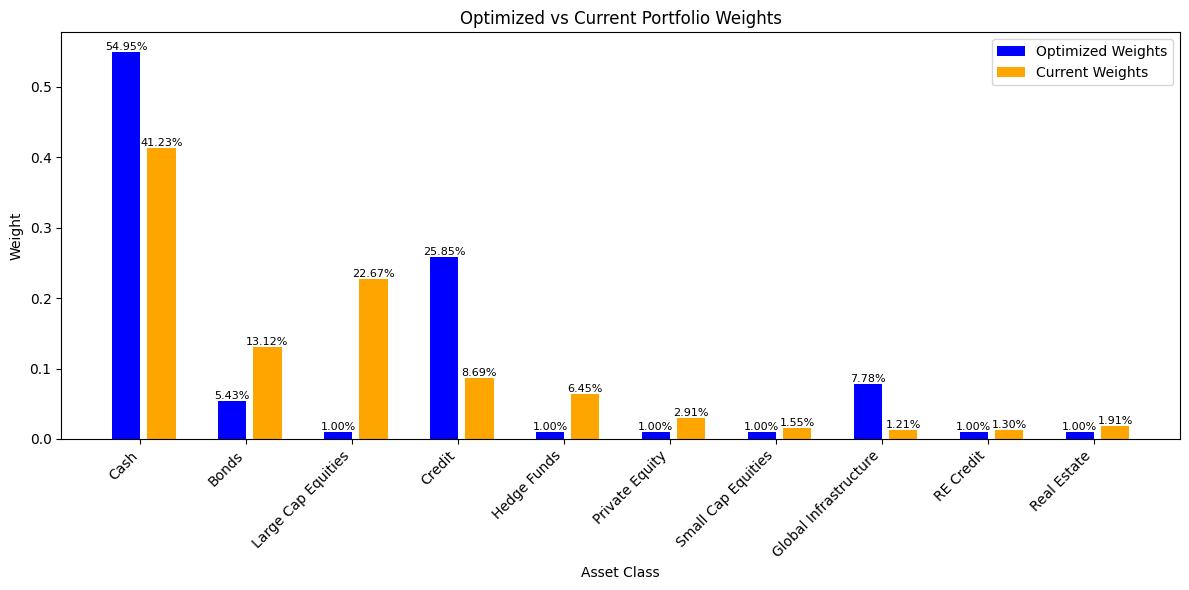

In [86]:
# Plot the optimized weights
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Credit', 'Hedge Funds', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

current_weights = np.array([0.4123, 0.1312, 0.2267, 0.0869, 0.0645, 0.0291, 0.0155, 0.0121, 0.013, 0.0191])

# Asset names
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Credit', 'Hedge Funds', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']

# Create a range for the x-axis with larger space between asset classes
x_values = np.arange(len(optimized_weights)) * 3

# Plot the bar chart for the optimized weights
plt.figure(figsize=(12, 6))
bars_opt = plt.bar(x_values - 0.4, optimized_weights, width=0.8, label='Optimized Weights', color='blue')

# Overlay the bar chart for the current portfolio weights
bars_curr = plt.bar(x_values + 0.6, current_weights, width=0.8, label='Current Weights', color='orange')

plt.title('Optimized vs Current Portfolio Weights')
plt.xlabel('Asset Class')
plt.ylabel('Weight')
plt.xticks(x_values, asset_names, rotation=45, ha='right')

# Annotate each bar with the percentage value for optimized weights
for bar, weight in zip(bars_opt, optimized_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)

# Annotate each bar with the percentage value for current weights
for bar, weight in zip(bars_curr, current_weights):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{weight:.2%}', ha='center', va='bottom', fontsize=8)


# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
optimized_weights

array([0.54946712, 0.05428777, 0.01000001, 0.25847886, 0.01000003,
       0.01000002, 0.01000001, 0.07776617, 0.01000001, 0.01000001])

In [8]:
pd.DataFrame(cov_matrix)

,0,1,2,3,4,5,6,7,8,9
0,0.00001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00000,0.050028,-0.018224,-0.006264,0.038845,-0.024201,-0.024160,-0.013938,0.004533,0.004644
2,0.00000,-0.018224,0.176954,0.046707,0.029042,0.192242,0.184436,0.145091,0.095096,0.095852
3,0.00000,-0.006264,0.046707,0.066992,0.009362,0.057419,0.054981,0.043366,0.030018,0.027584
4,0.00000,0.038845,0.029042,0.009362,0.059994,0.037593,0.035150,0.032949,0.044834,0.037214
5,0.00000,-0.024201,0.192242,0.057419,0.037593,0.322699,0.231757,0.170403,0.121799,0.117606
6,0.00000,-0.024160,0.184436,0.054981,0.035150,0.231757,0.222735,0.163798,0.115567,0.110584
7,0.00000,-0.013938,0.145091,0.043366,0.032949,0.170403,0.163798,0.211833,0.100694,0.086458
8,0.00000,0.004533,0.095096,0.030018,0.044834,0.121799,0.115567,0.100694,0.097574,0.088195
9,0.00000,0.004644,0.095852,0.027584,0.037214,0.117606,0.110584,0.086458,0.088195,0.109885


In [9]:
corr

1,U.S. cash,U.S. government bonds (all maturities),U.S. large cap equities,Hedge funds (global),U.S. credit (all maturities),U.S. private equity (buyout),U.S. small cap equities,Global infrastructure equity,Real estate mezzanine debt,U.S. core real estate
Asset,,,,,,,,,,
U.S. cash,1,0,0,0,0,0,0,0,0,0
U.S. government bonds (all maturities),0,1,-0.19369,-0.1082,0.70904,-0.19047,-0.22887,-0.13539,0.06488,0.06264
U.S. large cap equities,0,-0.19369,1,0.42898,0.28187,0.80449,0.92901,0.7494,0.72371,0.68739
Hedge funds (global),0,-0.1082,0.42898,1,0.14768,0.39052,0.4501,0.36403,0.37128,0.32149
U.S. credit (all maturities),0,0.70904,0.28187,0.14768,1,0.27018,0.30407,0.29228,0.58599,0.45834
U.S. private equity (buyout),0,-0.19047,0.80449,0.39052,0.27018,1,0.86445,0.65175,0.6864,0.62454
U.S. small cap equities,0,-0.22887,0.92901,0.4501,0.30407,0.86445,1,0.75408,0.78392,0.70685
Global infrastructure equity,0,-0.13539,0.7494,0.36403,0.29228,0.65175,0.75408,1,0.70039,0.56668
Real estate mezzanine debt,0,0.06488,0.72371,0.37128,0.58599,0.6864,0.78392,0.70039,1,0.85174


In [35]:
variances

array([1.00000000e-05, 5.00283460e-02, 1.76953802e-01, 6.69924800e-02,
       5.99935620e-02, 3.22698929e-01, 2.22735253e-01, 2.11832885e-01,
       9.75741340e-02, 1.09885174e-01])

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.002503,-0.001715,-0.000363,0.002128,-0.003075,-0.00255,-0.001435,0.000317,0.000344
2,0.0,-0.001715,0.031313,0.005085,0.002992,0.045939,0.036616,0.028091,0.012496,0.013366
3,0.0,-0.000363,0.005085,0.004488,0.000594,0.008442,0.006716,0.005166,0.002427,0.002367
4,0.0,0.002128,0.002992,0.000594,0.003599,0.005231,0.004063,0.003714,0.00343,0.003022
5,0.0,-0.003075,0.045939,0.008442,0.005231,0.104135,0.062134,0.044552,0.021613,0.022146
6,0.0,-0.00255,0.036616,0.006716,0.004063,0.062134,0.049611,0.035579,0.017037,0.0173
7,0.0,-0.001435,0.028091,0.005166,0.003714,0.044552,0.035579,0.044873,0.014477,0.013191
8,0.0,0.000317,0.012496,0.002427,0.00343,0.021613,0.017037,0.014477,0.009521,0.009132
9,0.0,0.000344,0.013366,0.002367,0.003022,0.022146,0.0173,0.013191,0.009132,0.012075


In [65]:
corr.values

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, -0.19369, -0.1082, 0.70904, -0.19047, -0.22887, -0.13539,
        0.06488, 0.06264],
       [0, -0.19369, 1, 0.42898, 0.28187, 0.80449, 0.92901, 0.7494,
        0.72371, 0.68739],
       [0, -0.1082, 0.42898, 1, 0.14768, 0.39052, 0.4501, 0.36403,
        0.37128, 0.32149],
       [0, 0.70904, 0.28187, 0.14768, 1, 0.27018, 0.30407, 0.29228,
        0.58599, 0.45834],
       [0, -0.19047, 0.80449, 0.39052, 0.27018, 1, 0.86445, 0.65175,
        0.6864, 0.62454],
       [0, -0.22887, 0.92901, 0.4501, 0.30407, 0.86445, 1, 0.75408,
        0.78392, 0.70685],
       [0, -0.13539, 0.7494, 0.36403, 0.29228, 0.65175, 0.75408, 1,
        0.70039, 0.56668],
       [0, 0.06488, 0.72371, 0.37128, 0.58599, 0.6864, 0.78392, 0.70039,
        1, 0.85174],
       [0, 0.06264, 0.68739, 0.32149, 0.45834, 0.62454, 0.70685, 0.56668,
        0.85174, 1]], dtype=object)

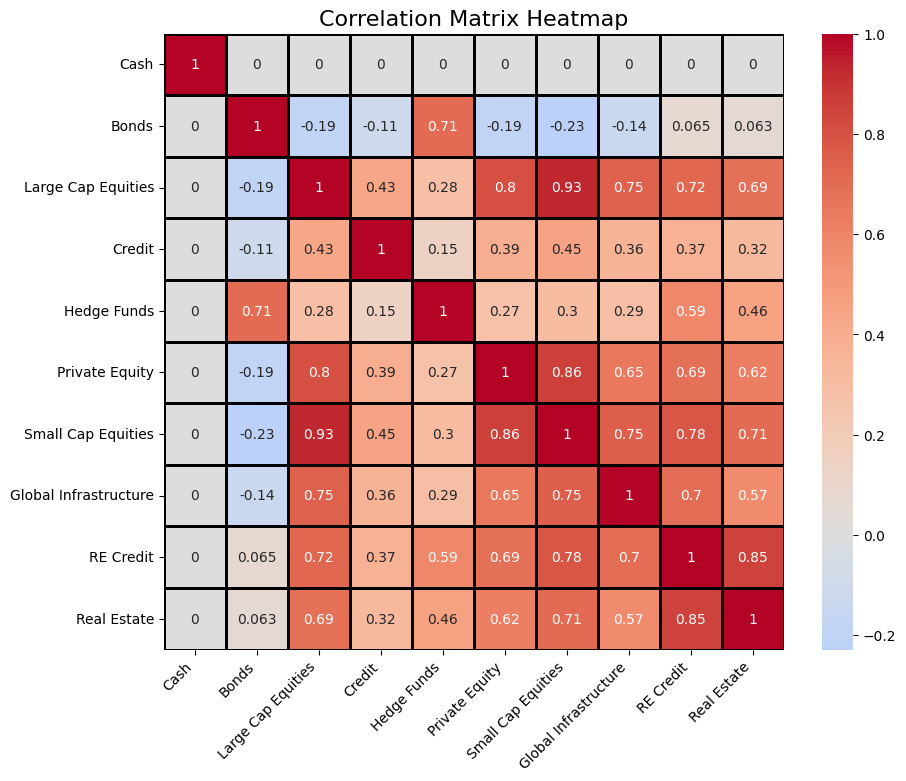

In [71]:
# Convert to DataFrame
asset_names = ['Cash', 'Bonds', 'Large Cap Equities', 'Credit', 'Hedge Funds', 'Private Equity', 'Small Cap Equities', 'Global Infrastructure', 'RE Credit', 'Real Estate']
correlation_df = pd.DataFrame(corr.values, index=asset_names, columns=asset_names)

# Handle NaN values if any (e.g., fill NaNs with 0)
correlation_df = correlation_df.fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=1, linecolor='black')

# Add titles and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()